# Likelihood-Free Inference - Model Training

Ali Al Kadhim and Harrison B. Prosper<br>
Department of Physics, Florida State University<br>
Date: 22 April 2022

## Introduction

See __LFI_generate_data.ipynb__, __LFI_train.ipynb__ and __LFI_train1.ipynb__.

## The Poisson Problem: Two Counts

In this notebook, we consider the statistical model

\begin{align}
\textrm{P}(n, m, \theta, \nu) & = \frac{e^{-(\theta + \nu)} (\theta + \nu)^n}{n!}
\frac{e^{-\nu} \nu^m}{m!}
\end{align}

which, as noted in __LFI_generate_data__, is the prototype of many
statistical models in astronomy and particle physics.


### References
  1. Anne Lee et al., https://arxiv.org/abs/2107.03920
  2. Neyman, Jerzy (1937). "Outline of a Theory of Statistical Estimation Based on the Classical Theory of Probability". Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences. 236 (767): 333–380. doi:10.1098/rsta.1937.0005.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard symbolic algebra module
#import sympy as sm
#sm.init_printing()

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn
#from torch.utils.data import Dataset

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

# written out by LFI_generate1.ipynb
import LFIutil as lfi

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load data

In [20]:
datafile = 'data2.db'
print('loading %s' % datafile)
data = jb.load(datafile)

MLE  = False
if MLE:
    target = 'Z1'
    WHICH  = 'MLE'
else:
    target = 'Z2'
    WHICH  = 'nonMLE'
    
source = ['theta', 'nu', 'N', 'M']

data[:5]

loading data2.db


,Z1,Z2,theta,nu,N,M
0,1,1,11.533029,19.310152,6,6
1,1,1,15.176765,11.956888,8,1
2,1,1,13.631740,11.587822,1,6
3,1,1,4.812053,2.007951,1,0
4,1,1,13.989596,19.715774,6,6


### Plot data

In [21]:
# Check that histogrammed data agrees with exact calculation of DL.

XMIN  = 0
XMAX  = 20
XBINS = 200
NU    = 3
D     = [(1, 0), (2, 0), (3, 0), 
         (1, 1), (2, 1), (3, 1)]

def hist_data(nu, N, M,
              xbins=XBINS,
              xmin=XMIN, 
              xmax=XMAX,
              mle=MLE,
              Ndata=100000):

    theta = st.uniform.rvs(xmin, xmax, size=Ndata)
    n = st.poisson.rvs(theta + nu)
    m = st.poisson.rvs(nu, size=Ndata)
    Z = (lfi.t2(theta, n, m, mle) < 
         lfi.t2(theta, N, M, mle)).astype(np.int32)

    xrange = (xmin, xmax)

    # weighted histogram   (count the number of ones per bin)
    y1, bb = np.histogram(theta, 
                          bins=xbins, 
                          range=xrange, 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(theta, 
                         bins=xbins, 
                         range=xrange)

    y =  y1 / yt    
    
    return y, bb

In [22]:
def plot_data(nu, D, 
              func=None,
              xbins=XBINS,
              xmin=XMIN, 
              xmax=XMAX,
              gfile='fig_data2_%s.png' % WHICH, 
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = hist_data(nu, N, M)
    
        ax[j].set_xlim(xmin, xmax)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='approx')
        
        if func:
            p, _ = func(nu, N, M)
            ax[j].plot(x, p, 'r', lw=2, label='exact')
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   fontsize=FONTSIZE) 

        ax[j].text(10.1, 0.30, r'$\nu = %5.1f$' % nu, 
                   fontsize=FONTSIZE) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    print('saving..', gfile)
    plt.savefig(gfile)
    plt.show()

saving.. fig_data2_nonMLE.png


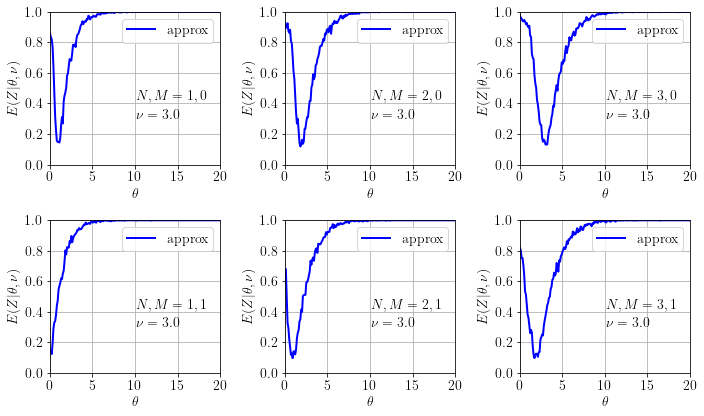

In [23]:
plot_data(NU, D) 

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [24]:
# Fraction of the data assigned as test data
fraction = 1/102
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 1/101
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes and drop the old ones
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5][source]

train set size:        500000
validation set size:     5000
test set size:           5000


,theta,nu,N,M
0,13.689324,17.072412,0,4
1,6.700971,14.679539,2,5
2,0.135762,9.366712,2,4
3,6.610225,16.550917,9,7
4,3.037118,4.901128,3,2


Split data into targets $t$ and inputs $\mathbf{x}$

In [25]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

train_t, train_x = split_t_x(train_data, target, source)
valid_t, valid_x = split_t_x(valid_data, target, source)
test_t,  test_x  = split_t_x(test_data,  target, source)

### Return a (random) batch of data from the training set

In [26]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined as

\begin{align}
R_M(\theta) & = \frac{1}{M}\sum_{m=1}^M L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta),\\ \\ \textrm{and} \\
    L(t, f) &= (t - f)^2
\end{align*}

The empirical risk $R_M$ approximates the __risk__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x},
\end{align}

which is a __functional__ of the model $f$. The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

In [27]:
# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

This function is used to validate the model while the it is being fitted.

In [28]:
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t)

### Function to execute training loop

In [29]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()      
    return (xx, yy_t, yy_v)

In [30]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

### Define model $f(\mathbf{x}, \theta)$

In [66]:
%%writefile dnnmodel2.py

import torch
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, n_inputs=4, n_nodes=25, n_layers=5):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y


Overwriting dnnmodel2.py


### Train!

Instantiate model and an optimizer, then train

In [67]:
import dnnmodel2
importlib.reload(dnnmodel2)
model = dnnmodel2.Model()
print(model)

learning_rate = 1.e-3
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ([], [], [])
traces_step = 10

Model(
  (layer0): Linear(in_features=4, out_features=25, bias=True)
  (layer1): Linear(in_features=25, out_features=25, bias=True)
  (layer2): Linear(in_features=25, out_features=25, bias=True)
  (layer3): Linear(in_features=25, out_features=25, bias=True)
  (layer4): Linear(in_features=25, out_features=25, bias=True)
  (layer5): Linear(in_features=25, out_features=1, bias=True)
)


In [68]:
n_batch       = 32
n_iterations  = 20000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

n_batch       = 500
n_iterations  = 10000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

plot_average_loss(traces)

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.237907	  0.238400
      8030	  0.050673	  0.056370

KeyboardInterrupt: 

In [62]:
def usemodel(nu, N, M,
             xbins=XBINS,
             xmin=XMIN,
             xmax=XMAX):
    
    xstep = (xmax-xmin) / xbins
    bb    = np.arange(xmin, xmax+xstep, xstep)
    X     = (bb[1:] + bb[:-1])/2
    X     = torch.Tensor([[x, nu, N, M] for x in X])
    
    model.eval()
    return model(X).detach().numpy(), bb

saving.. fig_model_vs_DL_nonMLE.png


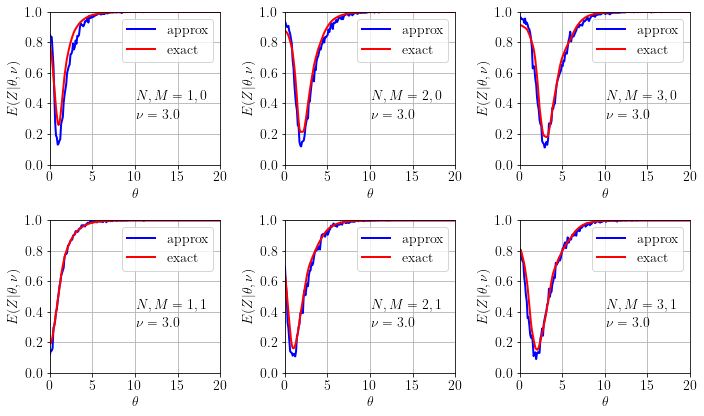

In [63]:
plot_data(NU, D, 
          func=usemodel, 
          gfile='fig_model_vs_DL_%s.png' % WHICH) 